In [168]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [169]:
df = pd.read_csv("rfm_data.csv")
df

,Unnamed: 0,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,0,1,210,580717
1,1,7,140,293678
2,2,11,135,283712
3,3,97,23,281336
4,4,5,152,309928
...,...,...,...,...
62983,62983,297,2,1134
62984,62984,89,4,8016
62985,62985,29,2,2594
62986,62986,400,2,3934


In [170]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LAST_TO_END   62988 non-null  int64
 1   FLIGHT_COUNT  62988 non-null  int64
 2   SEG_KM_SUM    62988 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [172]:
df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


In [173]:
def cluster_maker(dataframe, n_cluster_lts):
    kmeans = KMeans(n_clusters=n_cluster_lts, init='k-means++', random_state=42).fit(dataframe)

    dataframe['distance_to_centroid'] = np.min(kmeans.transform(dataframe), axis=1)
    dataframe['cluster_id'] = kmeans.labels_

    return dataframe

In [174]:
def separate_dataframe(dataframe, n_cluster_lts, sort_column='distance_to_centroid'):
    cluster_dfs = {}

    for i in range(n_cluster_lts):
        cluster_dfs[i] = [dataframe[dataframe['cluster_id'] == i]]
        cluster_dfs[i][0] = cluster_dfs[i][0].sort_values(sort_column, ascending=False)
        
    return cluster_dfs

In [175]:
def trimmed_outlier(dataframe, n_cluster_lts, trim_percent, distance_column='distance_to_centroid'):
    dataframe_dict = separate_dataframe(dataframe=dataframe, n_cluster_lts=n_cluster_lts)
    outlier_dfs = {}

    for i in range(n_cluster_lts):
        
        rows_to_keep = int((trim_percent) / 100 *len(dataframe_dict[i][0]))
        threshold = dataframe_dict[i][0][distance_column].head(rows_to_keep).values[-1]

        outliers = dataframe_dict[i][0][dataframe_dict[i][0][distance_column] > threshold]

        dataframe_dict[i][0] = dataframe_dict[i][0][dataframe_dict[i][0][distance_column] <= threshold]

        outlier_dfs[i] = outliers.copy()

    inliers = pd.concat([dataframe_dict[i][0] for i in range(n_cluster_lts)], ignore_index=True)
    outliers = pd.concat([outlier_dfs[i] for i in range(n_cluster_lts)], ignore_index=True)

    return inliers, outliers

In [176]:
def best_percentage(dataframe, n_cluster_lts):
    trim_percent = [5, 10, 15, 20, 25, 30]
    best_silhouette_score = 0
    best_trimmed_df = None
    best_trim_percent = 0
    best_inliers = None
    best_outliers = None

    for percent in trim_percent:
        inliers, outliers = trimmed_outlier(dataframe=dataframe, n_cluster_lts=n_cluster_lts, trim_percent=percent)

        if inliers is not None:

            relevant_cols = inliers.iloc[:, :-2]
            labels = inliers.iloc[:, -1]
            score = silhouette_score(relevant_cols, labels)

            if score > best_silhouette_score:
                best_silhouette_score = score
                best_trim_percent = percent
                
                outliers['cluster_id'] = outliers.iloc[:, -1].replace(to_replace=(0, 1), value=("0-out", "1-out"))
                best_inliers = inliers
                best_outliers = outliers
    
    
    best_trimmed_df = pd.concat([best_inliers, best_outliers], axis=0)

    return best_trim_percent, best_silhouette_score, best_trimmed_df

In [177]:
def K_MEANS_LTS(dataframe, n_cluster_lts):
    df_cluster = cluster_maker(dataframe=dataframe, n_cluster_lts=n_cluster_lts)
    best_trim_percent, best_silhouette_score, best_df = best_percentage(df_cluster, n_cluster_lts=n_cluster_lts)

    return best_trim_percent, best_silhouette_score, best_df

best_percent, best_silhouette_score, best_trimmed_df = K_MEANS_LTS(df, 2)
print("Best Percentage: ", best_percent)
print("Best Silhouette Score: ", best_silhouette_score)
print("=================================")
best_trimmed_df

Best Percentage:  30
Best Silhouette Score:  0.863874603767359


,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,distance_to_centroid,cluster_id
0,268,4,2788,8486.918475,0
1,235,2,2788,8486.694699,0
2,644,2,2800,8486.552514,0
3,611,3,2799,8485.863354,0
4,627,2,2800,8485.667330,0
...,...,...,...,...,...
18889,21,39,40309,22165.558067,1-out
18890,29,23,40324,22150.558675,1-out
18891,129,29,40329,22145.729521,1-out
18892,13,22,40331,22143.573431,1-out


In [113]:
best_trimmed_df.drop('distance_to_centroid', axis=1, inplace=True)

<Figure size 800x800 with 0 Axes>

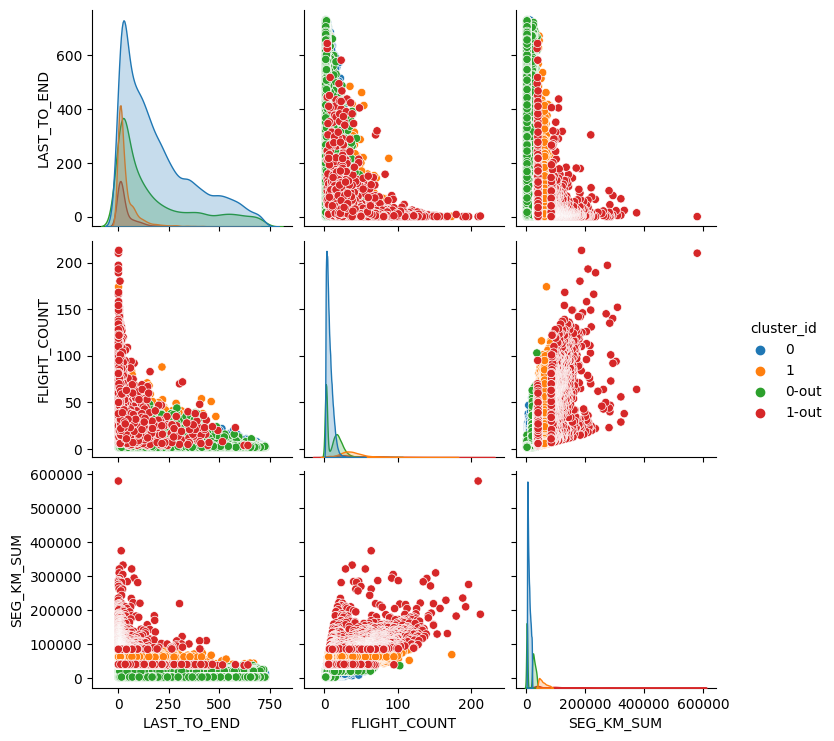

In [115]:
import seaborn as sns 

plt.figure(figsize=(8,8))
sns.pairplot(data=best_trimmed_df, hue='cluster_id')

In [118]:
best_trimmed_df_filtered = best_trimmed_df.loc[~best_trimmed_df['cluster_id'].isin(["1-out", "0-out"]), :]
best_trimmed_df_filtered

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,cluster_id
0,268,4,2788,0
1,235,2,2788,0
2,644,2,2800,0
3,611,3,2799,0
4,627,2,2800,0
...,...,...,...,...
44089,2,38,62453,1
44090,13,24,62496,1
44091,56,6,62468,1
44092,11,42,62490,1


In [125]:
best_trimmed_df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,cluster_id
0,268,4,2788,0
1,235,2,2788,0
2,644,2,2800,0
3,611,3,2799,0
4,627,2,2800,0
...,...,...,...,...
18889,21,39,40309,1-out
18890,29,23,40324,1-out
18891,129,29,40329,1-out
18892,13,22,40331,1-out


In [129]:
df_real = df.loc[:, df.columns.isin(['LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM'])]
df_real

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


In [133]:
best_trimmed_df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM,cluster_id
0,268,4,2788,0
1,235,2,2788,0
2,644,2,2800,0
3,611,3,2799,0
4,627,2,2800,0
...,...,...,...,...
18889,21,39,40309,1-out
18890,29,23,40324,1-out
18891,129,29,40329,1-out
18892,13,22,40331,1-out


In [141]:
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_real)

df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_pca['cluster_id'] = best_trimmed_df['cluster_id']
df_pca

C:\Users\Asus\AppData\Local\Temp\ipykernel_10504\1347198988.py:8: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  df_pca['cluster_id'] = best_trimmed_df['cluster_id']


ValueError: cannot reindex on an axis with duplicate labels